# <b> Text classification with tf.keras

In this notebook, we will classify reviews of IMDB dataset

<b> Importing packages</b>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0-dev20200514


In this notebook, we will be using tensorflow developer version 2.3.0-dev20200514 for our task in hand.

<b> Loading data </b>

In [2]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  10.8M      0  0:00:07  0:00:07 --:--:-- 19.2M


IMDB review sentiment dataset is an open source dataset from standford.

<b>Checking directory structure</b>

In [3]:
# !ls will list the directory contents 
!ls #checking the folders downloaded

aclImdb  aclImdb_v1.tar.gz  sample_data


In [4]:
!ls aclImdb

imdbEr.txt  imdb.vocab	README	test  train


In [5]:
!ls aclImdb/train

labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


In [6]:
!ls aclImdb/test

labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt


In [7]:
import os
os.listdir('aclImdb/train/pos')[:5]

['1312_9.txt', '7551_10.txt', '12493_8.txt', '6284_7.txt', '3545_7.txt']

In [8]:
!cat aclImdb/train/pos/1312_9.txt #cat command will show the contents in the given path.

Chalk this one up in the win column, this was a superb movie. The acting performances were great and the script was equally great.<br /><br />Helen Hunt was magnificent as the Riverside police officer Gina Pulasky. Gina was a complex character. She was a rookie cop with the Riverside Police Dept. She ended up in an affair with a coworker that she knew had a wife and kids, all the while she took on the dangerous task of going undercover to catch a serial killer. <br /><br />Jeff Fahey (the Ray Liotta look alike) did a bang up job as the confused, often stammering, police officer that had an affair with Gina. He was stoic as an officer, but he was quite the opposite when it came to dealing with his feelings and his extra-marital affair.<br /><br />Steven Weber, most notably from the sitcom "Wings", did a nice job as the quiet, meek, underachieving sociopath. On the surface, he was an innocent loser, but beneath the surface lied a cold hearted killer. Weber really took on the persona of a

In [9]:
import os
os.listdir('aclImdb/train/neg')[:5]

['6925_3.txt', '823_4.txt', '8873_3.txt', '2474_1.txt', '6187_2.txt']

In [10]:
!cat aclImdb/train/neg/6925_3.txt #cat command will show the contents in the given path.

I feel much less generous with this film than others of its ilk. The portrayal of madmen in this century is always done with them being so totally bizarre as to be a different species. Their antics are so outrageous as to be totally fictionalized. Everyone is Napoleon or some other historical figure; or they have a fascination with chickens. They are on the make or beating each other up. It's as if the scriptwriter said, what can I make up for them to do, without an sense of what insanity or even mental illness is. Watch the wonderful human portrayal in "One Flew Over the Cuckoo's Nest" where the illnesses are believable and real. I once worked in a State Mental hospital. I didn't see any of these guys. These are too smart and calculating to make them come to life.

In [0]:
!rm -r aclImdb/train/unsup

*  We have two folders **train, test**. In **train** and **test** , we have another two folders **pos** and **neg** .
*  In **pos** folder, we have all the **positive** reviews.
*  In **neg** folder, we have all the **negative** reviews.

<b> Loading generators to train batch wise</b>

In [12]:
batch_size= 32 # considering batch_size =32

train_directory = tf.keras.preprocessing.text_dataset_from_directory(directory = "aclImdb/train",
                                                                     batch_size=batch_size,
                                                                     validation_split=0.2,
                                                                     subset="training",
                                                                     seed=24)

validation_directory = tf.keras.preprocessing.text_dataset_from_directory(directory = "aclImdb/train",
                                                                          batch_size=batch_size,
                                                                          validation_split=0.2,
                                                                          subset="validation",
                                                                          seed=24)

test_directory = tf.keras.preprocessing.text_dataset_from_directory(directory = "aclImdb/test",
                                                                    batch_size=batch_size,
                                                                    seed=24)

print('Number of batches in train_directory : %d'% tf.data.experimental.cardinality(train_directory))

print('Number of batches in validation_directory : %d'% tf.data.experimental.cardinality(validation_directory))

print('Number of batches in test_directory : %d' % tf.data.experimental.cardinality(test_directory))

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in train_directory : 625
Number of batches in validation_directory : 157
Number of batches in test_directory : 782


<b>Previewing few examples</b>

In [13]:
for text_data,label_data in train_directory.take(1):
  for i in range(3):
    print(text_data.numpy()[i])
    print(label_data.numpy()[i])

b'Although I was born in the year that this movie came out and had never heard of it until my junior year of high school (1996) when I saw it I became totally engrossed laughing and crying and feeling along with the characters because me and my friends were them.<br /><br />Their hair, clothes and speech were outdated but the emotions and the desperation of each situation were so familiar! I remember thinking how real it was and how I wished that they would make movies like that still.<br /><br />In fact I saw this movie the night after I had been at a crazy party (not so unlike the one in Jay\'s house) which had been crashed by what we considered the loser derelicts who hung out on the fringes of our crowd. A world class BS\'er and "responsible" mother figure type I identified immediately with Jeanie (I was also the one with a car) although I had a little bit of Madge\'s insecurities floating around in there too. My best friend was a Deidre and her good friend from childhood was our A

<b> Preprocessing and preparing the data to train </b>

*  Lowercasing data
*  Removing `<br />` tags
*  Removing punctuations

In [0]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re

#custom function

def custom_preprocess(input_data):
  ''' In this function, we will do preprocessing on text'''
  lower_case = tf.strings.lower(input_data)
  cleaned_tags = tf.strings.regex_replace(lower_case,'<br />',' ')
  return tf.strings.regex_replace(cleaned_tags,"[%s]" % re.escape(string.punctuation),'')

# model constraints 

max_features = 20000
embedding_dim = 128
max_sequence_length =500

# instantiating text vectorization layer

vectorize_layer = TextVectorization(standardize = custom_preprocess,max_tokens = max_features, output_mode="int",output_sequence_length = max_sequence_length,)

text_data = train_directory.map(lambda x, y: x) # considering only text data , no labels

vectorize_layer.adapt(text_data)

<b> Vectorizing data</b>

Here we are training on GPU. So, below code will help us **asynchronous CPU processing and buffering**.

In [0]:
def vectorize_text(text, label):
  '''In this function, we will expand the dimensions and will vectorize the data'''
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text),label

# vectorizing data

train_data = train_directory.map(vectorize_text)

val_data =  validation_directory.map(vectorize_text)

test_data = test_directory.map(vectorize_text)

# Asynchronous prefetching/ buffering on data for better performance on GPU.

train_data = train_data.cache().prefetch(buffer_size = 10)

val_data = val_data.cache().prefetch(buffer_size = 10)

test_data = test_data.cache().prefetch(buffer_size = 10)

### **Baseline model**

In [0]:
tf.keras.backend.clear_session()

In [17]:
from tensorflow.keras import layers

# here we  are using functional API
input = tf.keras.Input(shape=(None,),dtype='int64')

embedding_layer = layers.Embedding(max_features+1,embedding_dim)(input)

x = layers.Conv1D(16, 7, padding="valid", activation="relu", strides=3)(embedding_layer)

x = layers.Dropout(0.5)(x)

x = layers.Conv1D(16, 7, padding="valid", activation="relu", strides=3)(x)

x = layers.GlobalMaxPooling1D()(x)

x = layers.Dense(16, activation="relu")(x)

x = layers.Dropout(0.5)(x)

output = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(input, output)

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560128   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          14352     
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)               

In [18]:
history=model.fit(train_data,validation_data= val_data,epochs = 3)

Epoch 1/3
625/625 [==============================] - 23s 36ms/step - loss: 0.6125 - accuracy: 0.6244 - val_loss: 0.3723 - val_accuracy: 0.8498
Epoch 2/3
625/625 [==============================] - 18s 29ms/step - loss: 0.3484 - accuracy: 0.8614 - val_loss: 0.3124 - val_accuracy: 0.8696
Epoch 3/3
625/625 [==============================] - 18s 29ms/step - loss: 0.2249 - accuracy: 0.9226 - val_loss: 0.3103 - val_accuracy: 0.8742


In [19]:
history.history

{'accuracy': [0.6243500113487244, 0.8614000082015991, 0.9226499795913696],
 'loss': [0.61247718334198, 0.348408579826355, 0.22487841546535492],
 'val_accuracy': [0.8497999906539917, 0.8695999979972839, 0.8741999864578247],
 'val_loss': [0.37226778268814087, 0.3123539686203003, 0.3102637231349945]}

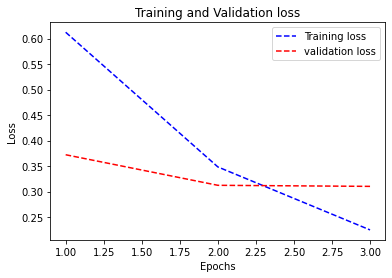

In [20]:
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,4)
plt.plot(epochs, loss_train, 'b--', label='Training loss')
plt.plot(epochs, loss_val, 'r--', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

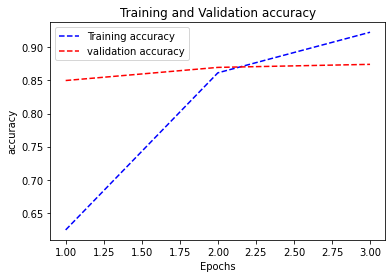

In [21]:
import matplotlib.pyplot as plt
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,4)
plt.plot(epochs, loss_train, 'b--', label='Training accuracy')
plt.plot(epochs, loss_val, 'r--', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

<b> Evaluating model on test data </b>

In [22]:
model.evaluate(test_data)

782/782 [==============================] - 9s 11ms/step - loss: 0.3550 - accuracy: 0.8567


[0.35500937700271606, 0.8566799759864807]

<b> Accuracy on test data is 85 %, it means that our model is doing pretty well.</b>

<b>End to end pipeline</b>

In [23]:
input = tf.keras.Input(shape=(1,),dtype='string') # giving string input

tokens = vectorize_layer(input) # string to tokens 

output = model(tokens) # prediction

#end to end model

end_to_end_model = tf.keras.Model(input,output)

end_to_end_model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

end_to_end_model.evaluate(test_directory) # testing with raw text data

782/782 [==============================] - 11s 14ms/step - loss: 0.3550 - accuracy: 0.8567


[0.35500964522361755, 0.8566799759864807]

**Reference**

*  https://keras.io/examples/nlp/text_classification_from_scratch/